In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import importlib
import sys
import os
import warnings
warnings.filterwarnings('ignore')
import joblib
# Add the src/ directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import utils
import Data
import Model
import Loss
import Inference
import Evaluator

utils.set_seed(seed=42)


# Load Processed Data

In [2]:
undisturbed_traces = np.load('../data/undisturbed_processed/undisturbed.npy',allow_pickle=True)
y_undisturbed_traces = np.load('../data/undisturbed_processed/y_undisturbed.npy',allow_pickle=True)

fold1_disturbed_traces = np.load('../data/fold1_processed/disturbed.npy',allow_pickle=True)
fold1_y_disturbed_traces = np.load('../data/fold1_processed/y_disturbed.npy',allow_pickle=True)

fold2_disturbed_traces = np.load('../data/fold2_processed/disturbed.npy',allow_pickle=True)
fold2_y_disturbed_traces = np.load('../data/fold2_processed/y_disturbed.npy',allow_pickle=True)

fold3_disturbed_traces = np.load('../data/fold3_processed/disturbed.npy',allow_pickle=True)
fold3_y_disturbed_traces = np.load('../data/fold3_processed/y_disturbed.npy',allow_pickle=True)

# Create Anomaly Ranges

In [3]:
# Updating anomaly range processing
fold1_anomaly_ranges = {}
for trace_index in range(len(fold1_y_disturbed_traces)):
    temp_anomaly_ranges = utils.create_anomaly_ranges(fold1_y_disturbed_traces[trace_index])  
    if trace_index not in fold1_anomaly_ranges:
        fold1_anomaly_ranges[trace_index] = {}
    for anomaly_type, ranges in temp_anomaly_ranges.items():
        if anomaly_type in fold1_anomaly_ranges[trace_index]:
            fold1_anomaly_ranges[trace_index][anomaly_type].extend(ranges)  # Append ranges if key already exists
        else:
            fold1_anomaly_ranges[trace_index][anomaly_type] = ranges  # Add new key if it doesn't exist

fold2_anomaly_ranges = {}
for trace_index in range(len(fold2_y_disturbed_traces)):
    temp_anomaly_ranges = utils.create_anomaly_ranges(fold2_y_disturbed_traces[trace_index])  
    if trace_index not in fold2_anomaly_ranges:
        fold2_anomaly_ranges[trace_index] = {}
    for anomaly_type, ranges in temp_anomaly_ranges.items():
        if anomaly_type in fold2_anomaly_ranges[trace_index]:
            fold2_anomaly_ranges[trace_index][anomaly_type].extend(ranges)
        else:
            fold2_anomaly_ranges[trace_index][anomaly_type] = ranges
    
fold3_anomaly_ranges = {}
for trace_index in range(len(fold2_y_disturbed_traces)):
    temp_anomaly_ranges = utils.create_anomaly_ranges(fold2_y_disturbed_traces[trace_index])  
    if trace_index not in fold3_anomaly_ranges:
        fold3_anomaly_ranges[trace_index] = {}
    for anomaly_type, ranges in temp_anomaly_ranges.items():
        if anomaly_type in fold3_anomaly_ranges[trace_index]:
            fold3_anomaly_ranges[trace_index][anomaly_type].extend(ranges)
        else:
            fold3_anomaly_ranges[trace_index][anomaly_type] = ranges


# Training

In [4]:
num_classes = 8  
window_size = 40
num_future_samples = 10
input_dim = 19 + num_classes # Number of features per time step
num_epochs = 50 # early stopping is applied
early_stopping_patience = 1
learning_rate = 0.00001 # scheduler is applied
lr_scheduler_patience = 1

In [5]:
# Best hyperparameters
setup1_config = {
    'batch_size': 64,
    'dataset_stride': 1,
    'dropout': 0.1,
    'embedding_size': 128,
    'num_heads': 8,
    'num_layers': 2
}

setup2_config = {
    'batch_size': 64,
    'dataset_stride': 1,
    'dropout': 0.5,
    'embedding_size': 128,
    'num_heads': 4,
    'num_layers': 2
}

setup3_config = {
    'batch_size': 64,
    'dataset_stride': 2,
    'dropout': 0.3,
    'embedding_size': 128,
    'num_heads': 4,
    'num_layers': 3
}


In [6]:
def prepare_dataset(traces, y_traces, stride, batch_size, isBatchOrganization, isReplacementExist):
        windows = utils.create_sliding_windows(traces, window_size, stride)
        windows_labels = utils.generate_labels_for_traces(traces, y_traces, window_size, stride)
        dataset = Data.DatasetCreator(windows, windows_labels, num_classes, num_future_samples, stride)
        if isBatchOrganization:
            if isReplacementExist:
                sampler = Data.BalancedBatchSampler(dataset, batch_size, minority_labels=[5], replacement=True)
            else:
                sampler = Data.BalancedBatchSampler(dataset, batch_size, minority_labels=[5], replacement=False)
            dataloader = DataLoader(dataset, batch_sampler=sampler)
        else:
            dataloader = DataLoader(dataset, batch_size, shuffle=True)
        
        class_weights = utils.calculate_scaled_class_weights(windows_labels, num_classes)

        return dataloader, class_weights

In [ ]:
importlib.reload(Model)
def train(train_traces, y_train_traces, val_traces, y_val_traces, config, isBatchOrganization=True, isReplacementExist=True, isClassWeightsAdjustment=True):

    device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')

    # DataLoader
    train_dataloader, train_class_weights = prepare_dataset(train_traces, y_train_traces, config['dataset_stride'], config['batch_size'], isBatchOrganization, isReplacementExist)
    val_dataloader, val_class_weights = prepare_dataset(val_traces, y_val_traces, config['dataset_stride'], config['batch_size'], isBatchOrganization, isReplacementExist)

    # Model
    model = Model.Predictor(
        input_dim=input_dim,
        embedding_size=config['embedding_size'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers'],
        num_classes=num_classes,
        window_size=window_size,
        num_future_samples=num_future_samples,
        dropout=config['dropout']
    )

    # Loss and optimizer
    if isClassWeightsAdjustment:
        criterion = Loss.Criterion(device, train_class_weights)
    else:
        criterion = Loss.Criterion(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=lr_scheduler_patience)

    # Train
    train_losses, val_losses = model.train_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        scheduler=scheduler,
        num_epochs=num_epochs,
        device=device,
        patience=early_stopping_patience
    )

    return model, train_losses, val_losses

Setup: 1
Epoch 1/50, Training Loss: 0.5676, Validation Loss: 0.3231, LR: 0.000010
Epoch 2/50, Training Loss: 0.2812, Validation Loss: 0.2366, LR: 0.000010
Epoch 3/50, Training Loss: 0.1867, Validation Loss: 0.1993, LR: 0.000010
Epoch 4/50, Training Loss: 0.1496, Validation Loss: 0.1814, LR: 0.000010
Epoch 5/50, Training Loss: 0.1308, Validation Loss: 0.1693, LR: 0.000010
Epoch 6/50, Training Loss: 0.1197, Validation Loss: 0.1639, LR: 0.000010
Epoch 7/50, Training Loss: 0.1118, Validation Loss: 0.1581, LR: 0.000010
Epoch 8/50, Training Loss: 0.1060, Validation Loss: 0.1557, LR: 0.000010
Epoch 9/50, Training Loss: 0.0996, Validation Loss: 0.1513, LR: 0.000010
Epoch 10/50, Training Loss: 0.0953, Validation Loss: 0.1471, LR: 0.000010
Epoch 11/50, Training Loss: 0.0920, Validation Loss: 0.1448, LR: 0.000010
Epoch 12/50, Training Loss: 0.0890, Validation Loss: 0.1457, LR: 0.000010
Early stopping triggered at epoch 12
Setup: 2
Epoch 1/50, Training Loss: 0.5456, Validation Loss: 0.5104, LR: 0.

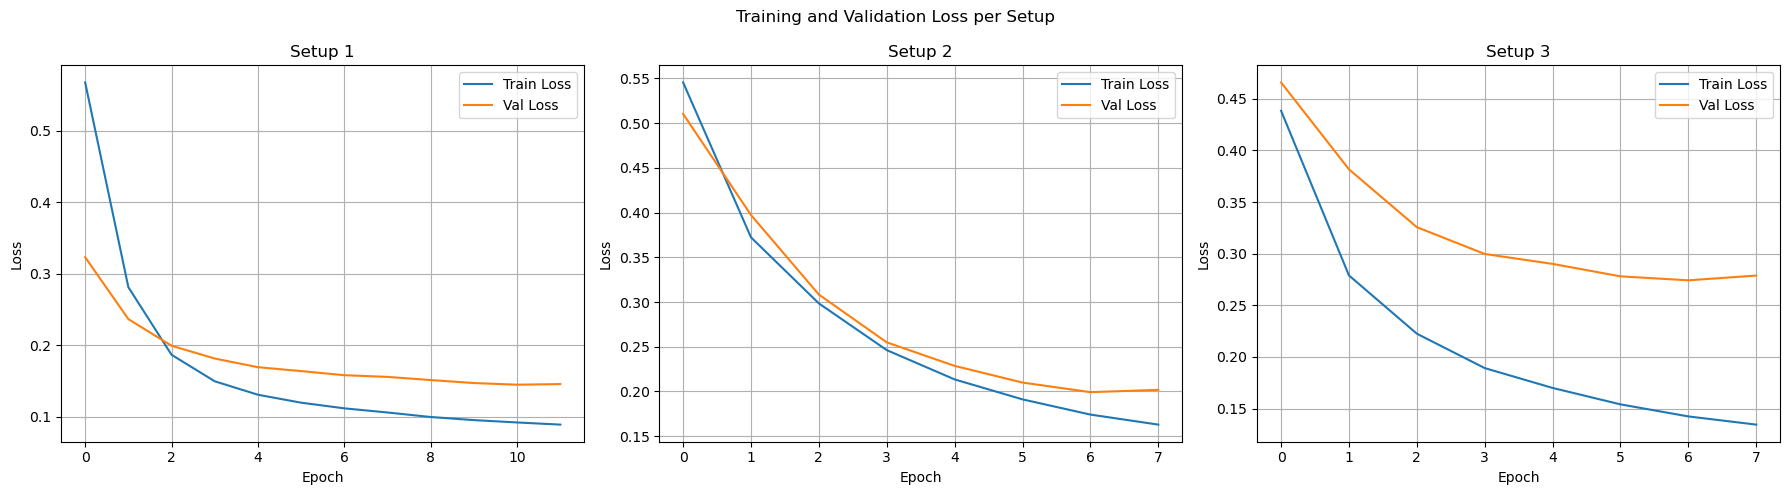

In [8]:
all_train_losses = []
all_val_losses = []
for i in range(1,4):
    
    if i == 1:
        train_traces = fold1_disturbed_traces
        y_train_traces = fold1_y_disturbed_traces
        val_traces = fold2_disturbed_traces
        y_val_traces = fold2_y_disturbed_traces
        config = setup1_config
    elif i == 2:
        train_traces = fold3_disturbed_traces
        y_train_traces = fold3_y_disturbed_traces
        val_traces = fold1_disturbed_traces
        y_val_traces = fold1_y_disturbed_traces
        config = setup2_config
    else:
        train_traces = fold2_disturbed_traces
        y_train_traces = fold2_y_disturbed_traces
        val_traces = fold3_disturbed_traces
        y_val_traces = fold3_y_disturbed_traces
        config = setup3_config
    
    print(f'Setup: {i}')
    model, train_losses, val_losses = train(train_traces, y_train_traces, val_traces, y_val_traces, config, isBatchOrganization=True, isReplacementExist=True, isClassWeightsAdjustment=True)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Save model
    joblib.dump(model, f'../models/setup{i}/model.joblib')
 
# Plot Training and validation Loss
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i in range(3):
    axes[i].plot(all_train_losses[i], label='Train Loss')
    axes[i].plot(all_val_losses[i], label='Val Loss')
    axes[i].set_title(f'Setup {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Training and Validation Loss per Setup")
plt.tight_layout()
plt.show()

# Inference

In [8]:
# --- Constants ---
stride = 1
majority_window_size = 3
device = "cpu"
modes = [1, 2, 3, 4]

# Define allowed transitions in a dictionary:
allowed_transitions = {
    # from 'a' (0): can go to any state
    0: [0, 1, 2, 3, 4, 5, 6, 7],
    # from 'b'(1), 'c'(2), 'd'(3), 'e'(4), 'f'(5), 'g'(6), 'u'(7): can go to itself or normal state
    1: [1, 0],
    2: [2, 0],
    3: [3, 0],
    4: [4, 0],
    5: [5, 0],
    6: [6, 0],
    7: [7, 0],
}

# Create time series patches
undisturbed_windows = utils.create_sliding_windows(undisturbed_traces, window_size, stride)
fold1_disturbed_windows = utils.create_sliding_windows(fold1_disturbed_traces, window_size, stride)
fold2_disturbed_windows = utils.create_sliding_windows(fold2_disturbed_traces, window_size, stride)
fold3_disturbed_windows = utils.create_sliding_windows(fold3_disturbed_traces, window_size, stride)

# Create labels
undisturbed_windows_labels  = utils.generate_labels_for_traces(undisturbed_traces, y_undisturbed_traces, window_size, stride)
fold1_disturbed_windows_labels = utils.generate_labels_for_traces(fold1_disturbed_traces, fold1_y_disturbed_traces, window_size, stride)
fold2_disturbed_windows_labels = utils.generate_labels_for_traces(fold2_disturbed_traces, fold2_y_disturbed_traces, window_size, stride)
fold3_disturbed_windows_labels = utils.generate_labels_for_traces(fold3_disturbed_traces, fold3_y_disturbed_traces, window_size, stride)

# Create true labels
fold1_true_labels = utils.extract_true_labels(fold1_disturbed_windows_labels, stride, num_future_samples)
fold2_true_labels = utils.extract_true_labels(fold2_disturbed_windows_labels, stride, num_future_samples)
fold3_true_labels = utils.extract_true_labels(fold3_disturbed_windows_labels, stride, num_future_samples)
undisturbed_true_labels = utils.extract_true_labels(undisturbed_windows_labels, stride, num_future_samples)

true_labels = []
true_labels.extend(fold1_true_labels)
true_labels.extend(fold2_true_labels)
true_labels.extend(fold3_true_labels)

In [27]:
importlib.reload(Inference)

# --- Dataset Configuration: each key is a split ---
configurations = {
    "train": [
        ("../models/setup1/model.joblib", "fold1_disturbed_windows", "fold1_disturbed_windows_labels"),
        ("../models/setup3/model.joblib", "fold2_disturbed_windows", "fold2_disturbed_windows_labels"),
        ("../models/setup2/model.joblib", "fold3_disturbed_windows", "fold3_disturbed_windows_labels")
    ],
    "val": [
        ("../models/setup2/model.joblib", "fold1_disturbed_windows", "fold1_disturbed_windows_labels"),
        ("../models/setup1/model.joblib", "fold2_disturbed_windows", "fold2_disturbed_windows_labels"),
        ("../models/setup3/model.joblib", "fold3_disturbed_windows", "fold3_disturbed_windows_labels")
    ],
    "test": [
        ("../models/setup3/model.joblib", "fold1_disturbed_windows", "fold1_disturbed_windows_labels"),
        ("../models/setup2/model.joblib", "fold2_disturbed_windows", "fold2_disturbed_windows_labels"),
        ("../models/setup1/model.joblib", "fold3_disturbed_windows", "fold3_disturbed_windows_labels")
    ]
}

# --- Loop through Train and Val ---
for split_name, setups in configurations.items():
    results = {mode: {"labels": [], "confidences": [], "probs": []} for mode in modes}

    for model_path, window_var, labels_var in setups:
        print(f"[{split_name}] Loading model from: {model_path}")
        model = joblib.load(model_path)
        model.to(device)

        inference = Inference.AutoregressiveForecaster(model, device, window_size, stride, num_future_samples, num_classes)

        windows = eval(window_var)
        labels = eval(labels_var)

        for mode in modes:
            pred_labels, confidences, probs = inference.forecast(
                windows, labels, allowed_transitions, mode, majority_window_size
            )
            results[mode]["labels"].extend(pred_labels)
            results[mode]["confidences"].extend(confidences)
            results[mode]["probs"].extend(probs)

    # Save results

    # Create output directory
    output_dir = f"results/setup{i}"
    os.makedirs(output_dir, exist_ok=True)
    
    joblib.dump(results, f"../results/{split_name}/disturbed_inference.joblib")


[train] Loading model from: ../models/setup1/model.joblib
[train] Loading model from: ../models/setup3/model.joblib
[train] Loading model from: ../models/setup2/model.joblib
[val] Loading model from: ../models/setup2/model.joblib
[val] Loading model from: ../models/setup1/model.joblib
[val] Loading model from: ../models/setup3/model.joblib
[test] Loading model from: ../models/setup3/model.joblib
[test] Loading model from: ../models/setup2/model.joblib
[test] Loading model from: ../models/setup1/model.joblib


In [28]:
importlib.reload(Inference)

for i in range(1, 4):

    model = joblib.load(f'../models/setup{i}/model.joblib')
    device = "cpu"
    model.to(device)
    inference = Inference.AutoregressiveForecaster(model, device, window_size, stride, num_future_samples, num_classes)

    undisturbed_mode1_predicted_labels, undisturbed_mode1_confidences, undisturbed_mode1_probs = inference.forecast(undisturbed_windows, undisturbed_windows_labels, allowed_transitions, mode=1)
    undisturbed_mode2_predicted_labels, undisturbed_mode2_confidences, undisturbed_mode2_probs = inference.forecast(undisturbed_windows, undisturbed_windows_labels, allowed_transitions, mode=2)
    undisturbed_mode3_predicted_labels, undisturbed_mode3_confidences, undisturbed_mode3_probs = inference.forecast(undisturbed_windows, undisturbed_windows_labels, allowed_transitions, mode=3, majority_window_size= majority_window_size)
    undisturbed_mode4_predicted_labels, undisturbed_mode4_confidences, undisturbed_mode4_probs = inference.forecast(undisturbed_windows, undisturbed_windows_labels, allowed_transitions, mode=4, majority_window_size= majority_window_size)

    # Package results into a dictionary
    result_dict = {
        "undisturbed_mode1_predicted_labels": undisturbed_mode1_predicted_labels,
        "undisturbed_mode1_confidences": undisturbed_mode1_confidences,
        "undisturbed_mode1_probs": undisturbed_mode1_probs,
        "undisturbed_mode2_predicted_labels": undisturbed_mode2_predicted_labels,
        "undisturbed_mode2_confidences": undisturbed_mode2_confidences,
        "undisturbed_mode2_probs": undisturbed_mode2_probs,
        "undisturbed_mode3_predicted_labels": undisturbed_mode3_predicted_labels,
        "undisturbed_mode3_confidences": undisturbed_mode3_confidences,
        "undisturbed_mode3_probs": undisturbed_mode3_probs,
        "undisturbed_mode4_predicted_labels": undisturbed_mode4_predicted_labels, 
        "undisturbed_mode4_confidences": undisturbed_mode4_confidences,
        "undisturbed_mode4_probs": undisturbed_mode4_probs
    }

    # Create output directory
    output_dir = f"results/setup{i}"
    os.makedirs(output_dir, exist_ok=True)

    # Save to disk using joblib
    joblib.dump(result_dict, f"../results/setup{i}/undisturbed_inference.joblib")


# Evaluation Metrics

In [13]:
# Undisturbed Metrics
importlib.reload(utils)
for i in range(1, 4):
    results = joblib.load(f"../results/setup{i}/undisturbed_inference.joblib")
    path = f"../results/setup{i}/"
    utils.save_undisturbed_results(path,"model",
        undisturbed_true_labels,
        results["undisturbed_mode1_predicted_labels"],
        results["undisturbed_mode2_predicted_labels"],
        results["undisturbed_mode3_predicted_labels"],
        results["undisturbed_mode4_predicted_labels"]
    )

In [14]:
importlib.reload(Evaluator)
importlib.reload(utils)

# Binary AD Metrics of Exathlon 
train_results = joblib.load(f"../results/train/disturbed_inference.joblib")
val_results = joblib.load(f"../results/val/disturbed_inference.joblib")
test_results = joblib.load(f"../results/test/disturbed_inference.joblib")
 
for i in range(1,5):  
    ad_levels = range(1, 5)
    global_f_scores_train = []
    global_precisions_train = []
    global_recalls_train = []
    type_wise_metrics_train = {anomaly_type: [] for anomaly_type in range(1,num_classes)}

    global_f_scores_val = []
    global_precisions_val = []
    global_recalls_val = []
    type_wise_metrics_val = {anomaly_type: [] for anomaly_type in range(1,num_classes)}

    global_f_scores_test = []
    global_precisions_test = []
    global_recalls_test = []
    type_wise_metrics_test = {anomaly_type: [] for anomaly_type in  range(1,num_classes)}

    # Initialize and compute metrics for each AD level
    for ad_level in ad_levels:
        evaluator = Evaluator.ADMetrics(beta=1.0, num_classes=num_classes, ad_level=ad_level)
        f_score_train, precision_train, recall_train, type_wise_metric_train = evaluator.compute_binary_metrics(true_labels, train_results[i]["labels"])
        f_score_val, precision_val, recall_val, type_wise_metric_val = evaluator.compute_binary_metrics(true_labels, val_results[i]["labels"])
        f_score_test, precision_test, recall_test, type_wise_metric_test = evaluator.compute_binary_metrics(true_labels, test_results[i]["labels"])

        # Global metrics
        global_f_scores_train.append(f_score_train)
        global_precisions_train.append(precision_train)
        global_recalls_train.append(recall_train)

        global_f_scores_val.append(f_score_val)
        global_precisions_val.append(precision_val)
        global_recalls_val.append(recall_val)

        global_f_scores_test.append(f_score_test)
        global_precisions_test.append(precision_test)
        global_recalls_test.append(recall_test)
    
        # Type-wise metrics
        for anomaly_type, metric in type_wise_metric_train.items():
            type_wise_metrics_train[anomaly_type].append(metric)
        for anomaly_type, metric in type_wise_metric_val.items():
            type_wise_metrics_val[anomaly_type].append(metric)
        for anomaly_type, metric in type_wise_metric_test.items():
            type_wise_metrics_test[anomaly_type].append(metric)
    
    utils.save_binary_AD_metrics(f'mode{i}', "../results/train/binary_AD_results.xlsx", ad_levels, global_f_scores_train, global_precisions_train, global_recalls_train, type_wise_metrics_train)
    utils.save_binary_AD_metrics(f'mode{i}', "../results/val/binary_AD_results.xlsx",  ad_levels, global_f_scores_val, global_precisions_val, global_recalls_val, type_wise_metrics_val)
    utils.save_binary_AD_metrics(f'mode{i}', "../results/test/binary_AD_results.xlsx",  ad_levels, global_f_scores_test, global_precisions_test, global_recalls_test, type_wise_metrics_test)

In [15]:
importlib.reload(Evaluator)
importlib.reload(utils)

# Multiclass AD Metrics of Exathlon 
train_results = joblib.load(f"../results/train/disturbed_inference.joblib")
val_results = joblib.load(f"../results/val/disturbed_inference.joblib")
test_results = joblib.load(f"../results/test/disturbed_inference.joblib")
 
for i in range(1,5):  
    ad_levels = range(1, 5)
    global_f_scores_train = []
    global_precisions_train = []
    global_recalls_train = []
    type_wise_metrics_train = {anomaly_type: [] for anomaly_type in range(1,num_classes)}

    global_f_scores_val = []
    global_precisions_val = []
    global_recalls_val = []
    type_wise_metrics_val = {anomaly_type: [] for anomaly_type in range(1,num_classes)}

    global_f_scores_test = []
    global_precisions_test = []
    global_recalls_test = []
    type_wise_metrics_test = {anomaly_type: [] for anomaly_type in range(1,num_classes)}

    # Initialize and compute metrics for each AD level
    for ad_level in ad_levels:
        evaluator = Evaluator.ADMetrics(beta=1.0, num_classes=num_classes, ad_level=ad_level)
        f_score_train, precision_train, recall_train, type_wise_metric_train = evaluator.compute_multiclass_metrics(true_labels, train_results[i]["labels"])
        f_score_val, precision_val, recall_val, type_wise_metric_val = evaluator.compute_multiclass_metrics(true_labels, val_results[i]["labels"])
        f_score_test, precision_test, recall_test, type_wise_metric_test = evaluator.compute_multiclass_metrics(true_labels, test_results[i]["labels"])

        # Global metrics
        global_f_scores_train.append(f_score_train)
        global_precisions_train.append(precision_train)
        global_recalls_train.append(recall_train)

        global_f_scores_val.append(f_score_val)
        global_precisions_val.append(precision_val)
        global_recalls_val.append(recall_val)

        global_f_scores_test.append(f_score_test)
        global_precisions_test.append(precision_test)
        global_recalls_test.append(recall_test)
        
        # Type-wise metrics
        for anomaly_type, metric in type_wise_metric_train.items():
            type_wise_metrics_train[anomaly_type].append(metric)  
        for anomaly_type, metric in type_wise_metric_val.items():
            type_wise_metrics_val[anomaly_type].append(metric)
        for anomaly_type, metric in type_wise_metric_test.items():
            type_wise_metrics_test[anomaly_type].append(metric)

    utils.save_multiclass_AD_metrics(f'mode{i}', "../results/train/multiclass_AD_results.xlsx", ad_levels, global_f_scores_train, global_precisions_train, global_recalls_train, type_wise_metrics_train)
    utils.save_multiclass_AD_metrics(f'mode{i}', "../results/val/multiClass_AD_results.xlsx",  ad_levels, global_f_scores_val, global_precisions_val, global_recalls_val, type_wise_metrics_val)
    utils.save_multiclass_AD_metrics(f'mode{i}', "../results/test/multiClass_AD_results.xlsx",  ad_levels, global_f_scores_test, global_precisions_test, global_recalls_test, type_wise_metrics_test)